In [ ]:
from keras.api import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.random.set_seed(1)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras.api.losses import CategoricalFocalCrossentropy, BinaryFocalCrossentropy
from keras.api.utils import to_categorical

# Sentiment classification

In [2]:
from keras.api.metrics import AUC, F1Score, Precision, Recall


model = models.Sequential()

model.add(layers.Input(shape=(26, 300), name="Domain_1"))

model.add(layers.Flatten())

model.add(layers.Dense(200, activation='relu', name="layer_1"))

model.add(layers.Dropout(0.2, name="dropout_3"))

model.add(layers.BatchNormalization(name="batch_normalization_3"))

model.add(layers.Dense(100, activation='relu', name="layer_2"))

model.add(layers.Dropout(0.2, name="dropout_4"))

model.add(layers.BatchNormalization(name="batch_normalization_4"))

model.add(layers.Dense(3, activation='softmax', name="sentiment"))

model.compile(
    optimizer='adam',
    loss = [CategoricalFocalCrossentropy(alpha=[0.079, 0.131, 0.790])],
    metrics=['accuracy', Recall(), Precision(), AUC(multi_label=True), F1Score(average='weighted')]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 7800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 200)            │     1,560,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sentiment (Dense)               │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,803 (6.03 MB)

 Trainable params: 1,581,203 (6.03 MB)

 Non-trainable params: 600 (2.34 KB)

In [3]:
df_original = pd.read_csv("data/processed/processed_tweets.csv")

In [4]:
df_with_unlabeled = df_original.copy()
df_with_unlabeled = df_with_unlabeled[df_with_unlabeled["Sentiment"].isna()]
df_original = df_original.dropna(subset=["Sentiment"])
df_original.info()

df_original["Sentiment"] = df_original["Sentiment"].map({-1: 0, 0: 1, 1: 2})

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              800 non-null    object 
 1   Sentiment         800 non-null    float64
 2   Has opinion       800 non-null    float64
 3   Unnamed: 3        1 non-null      float64
 4   cleaned_text      800 non-null    object 
 5   word_vectors      800 non-null    object 
 6   glove_vectors     800 non-null    object 
 7   fasttext_vectors  800 non-null    object 
dtypes: float64(3), object(5)
memory usage: 56.2+ KB


In [5]:
df_original["Sentiment"].value_counts()

Sentiment
0    470
1    283
2     47
Name: count, dtype: int64

In [6]:
padded_vectors = np.load("data/processed/padded_glove_vectors.npy")
padded_vectors = padded_vectors[:800]

one hot encoding

In [7]:
X_train, X_test, y_train, y_test = train_test_split(padded_vectors, df_original["Sentiment"], test_size=0.2, random_state=1, stratify=df_original["Sentiment"])
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [8]:
y_train_encoded

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [9]:
X_train.shape

(640, 26, 300)

In [10]:
y_train_encoded.shape

(640, 3)

In [11]:
unique_values, counts = np.unique(y_train, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 376
1: 226
2: 38


In [12]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 94
1: 57
2: 9


In [13]:
from keras.api.callbacks import EarlyStopping


callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(x=X_train, y=y_train_encoded, epochs=10, callbacks=callback)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3341 - auc: 0.5087 - f1_score: 0.3772 - loss: 0.1658 - precision: 0.3311 - recall: 0.2810
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5118 - auc: 0.7941 - f1_score: 0.5565 - loss: 0.0669 - precision: 0.5606 - recall: 0.4673
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6353 - auc: 0.8899 - f1_score: 0.6748 - loss: 0.0401 - precision: 0.6939 - recall: 0.5572
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7479 - auc: 0.9378 - f1_score: 0.7661 - loss: 0.0266 - precision: 0.7990 - recall: 0.6786
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8235 - auc: 0.9644 - f1_score: 0.8375 - loss: 0.0189 - precision: 0.8563 - recall: 0.7505
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8362 - auc: 0.9694 - f1_score: 0.8447 - loss: 0.0157 - precision: 0.8664 - recall: 0.7895
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8819 - au

In [14]:
model.save("models/experiments/experiment_2/experiment_2_sentiment_classification_model.keras")

Text(0.5, 0, 'epoch')

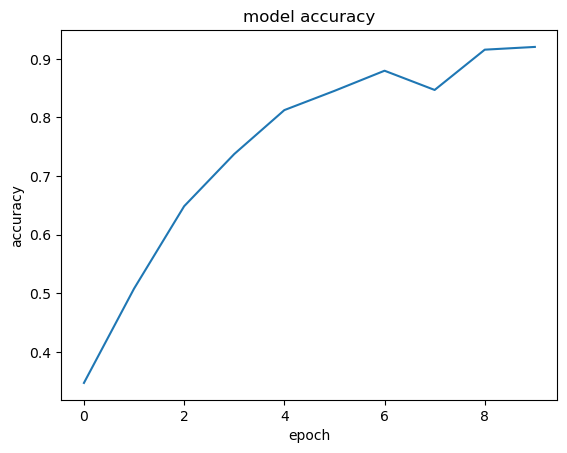

In [15]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

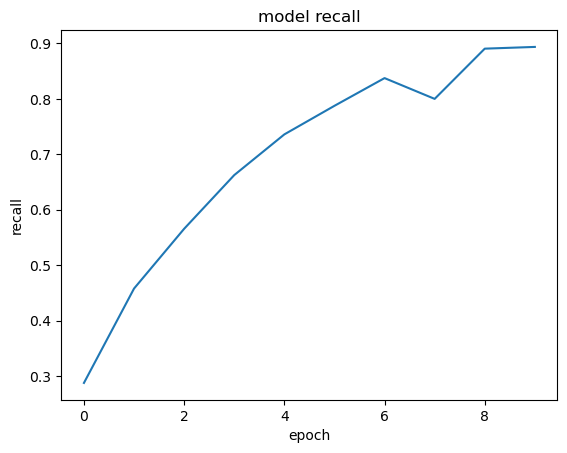

In [16]:
plt.plot(history.history['recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

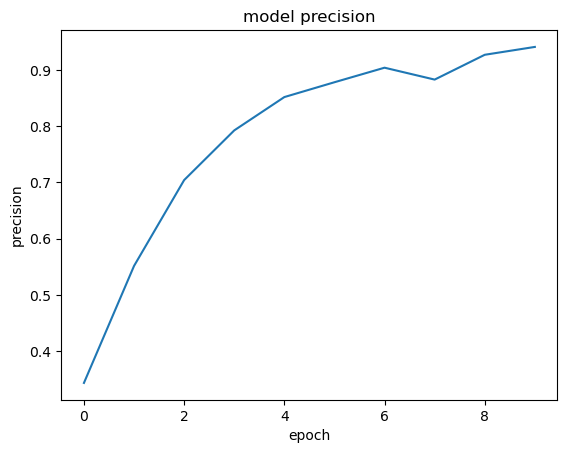

In [17]:
plt.plot(history.history['precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

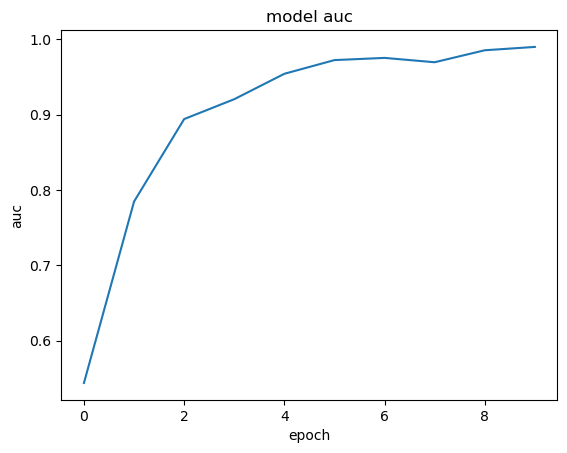

In [18]:
plt.plot(history.history['auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

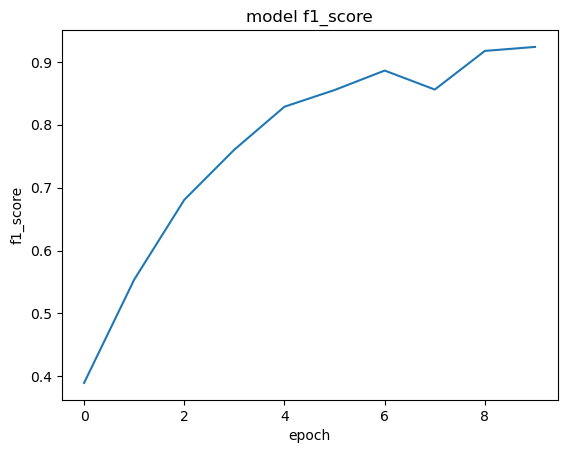

In [19]:
plt.plot(history.history['f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

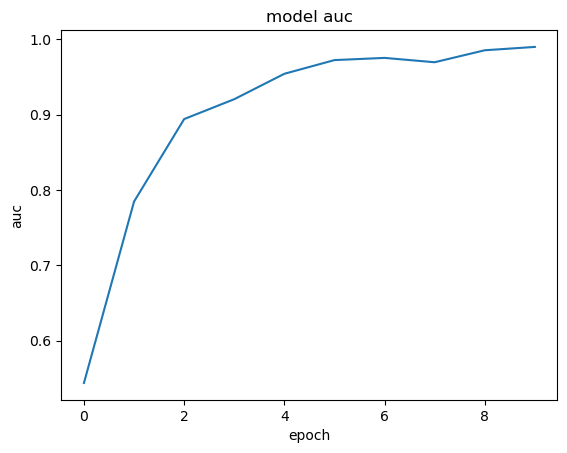

In [20]:
plt.plot(history.history['auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

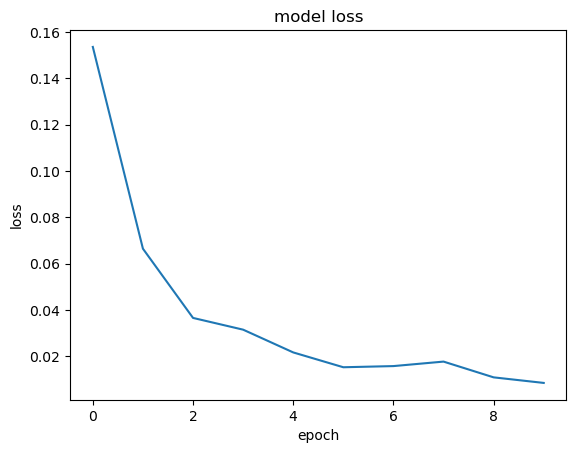

In [21]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [22]:
evaluation = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Loss: {evaluation[0]}, accuracy: {evaluation[1]}, Recall: {evaluation[2]}, Precision: {evaluation[3]}, AUC: {evaluation[4]}, F1-score: {evaluation[5]}')

Loss: 0.09831360727548599, accuracy: 0.59375, Recall: 0.48750001192092896, Precision: 0.5954198241233826, AUC: 0.6849896907806396, F1-score: 0.5934613347053528


In [23]:
predictions = model.predict(X_test).argmax(axis=1)
print("Unique values in predictions:", np.unique(predictions))

print("Unique values in y_test:", np.unique(y_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Unique values in predictions: [0 1 2]
Unique values in y_test: [0 1 2]


[[56 34  4]
 [17 38  2]
 [ 7  1  1]]


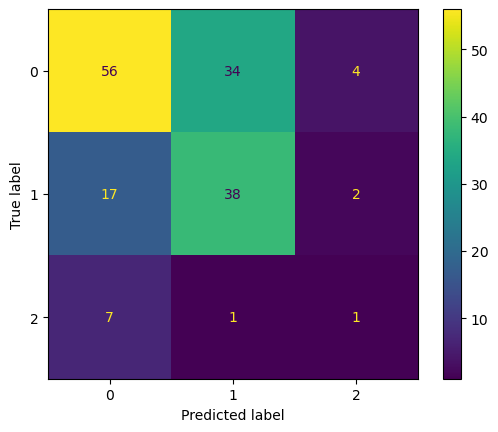

In [24]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)
display = ConfusionMatrixDisplay(matrix)
display.plot()

# Opinion detection

In [25]:
from keras.api.optimizers import Adam


model = models.Sequential()

model.add(layers.Input(shape=(26, 300), name="Domain_1"))

model.add(layers.Flatten())

model.add(layers.Dense(200, activation='relu', name="layer_1"))

model.add(layers.Dropout(0.2, name="dropout_3"))

model.add(layers.BatchNormalization(name="batch_normalization_3"))

model.add(layers.Dense(100, activation='relu', name="layer_2"))

model.add(layers.Dropout(0.2, name="dropout_4"))

model.add(layers.BatchNormalization(name="batch_normalization_4"))

model.add(layers.Dense(1, activation='sigmoid', name="opinion"))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=[BinaryFocalCrossentropy(alpha=0.48)],
    metrics=['accuracy', Recall(), Precision(), AUC(), F1Score(threshold=0.5)],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 7800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 200)            │     1,560,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ opinion (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,601 (6.03 MB)

 Trainable params: 1,581,001 (6.03 MB)

 Non-trainable params: 600 (2.34 KB)

In [26]:
df_original = pd.read_csv("data/processed/processed_tweets.csv")

In [27]:
df_with_unlabeled = df_original.copy()
df_with_unlabeled = df_with_unlabeled[df_with_unlabeled["Has opinion"].isna()]
df_original = df_original.dropna(subset=["Has opinion"])
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              800 non-null    object 
 1   Sentiment         800 non-null    float64
 2   Has opinion       800 non-null    float64
 3   Unnamed: 3        1 non-null      float64
 4   cleaned_text      800 non-null    object 
 5   word_vectors      800 non-null    object 
 6   glove_vectors     800 non-null    object 
 7   fasttext_vectors  800 non-null    object 
dtypes: float64(3), object(5)
memory usage: 56.2+ KB


In [28]:
df_original["Has opinion"].value_counts()

Has opinion
0.0    415
1.0    385
Name: count, dtype: int64

In [29]:
padded_vectors = np.load("data/processed/padded_glove_vectors.npy")
padded_vectors = padded_vectors[:800]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(padded_vectors, df_original["Has opinion"], test_size=0.2, random_state=1)
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

In [31]:
from keras.api.callbacks import EarlyStopping


callback = EarlyStopping(monitor='loss', patience=5)
history = model.fit(x=X_train, y=y_train, epochs=5, callbacks=callback)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5357 - auc_1: 0.5549 - f1_score: 0.5034 - loss: 0.4479 - precision_1: 0.5003 - recall_1: 0.5073
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7678 - auc_1: 0.8451 - f1_score: 0.7364 - loss: 0.1542 - precision_1: 0.7496 - recall_1: 0.7241
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8077 - auc_1: 0.9040 - f1_score: 0.8001 - loss: 0.1156 - precision_1: 0.8094 - recall_1: 0.7926
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8757 - auc_1: 0.9622 - f1_score: 0.8713 - loss: 0.0700 - precision_1: 0.9049 - recall_1: 0.8418
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9356 - auc_1: 0.9798 - f1_score: 0.9317 - loss: 0.0488 - precision_1: 0.9590 - recall_1: 0.9063


In [32]:
model.save("models/experiments/experiment_2/experiment_2_opinion_detection_model.keras")

Text(0.5, 0, 'epoch')

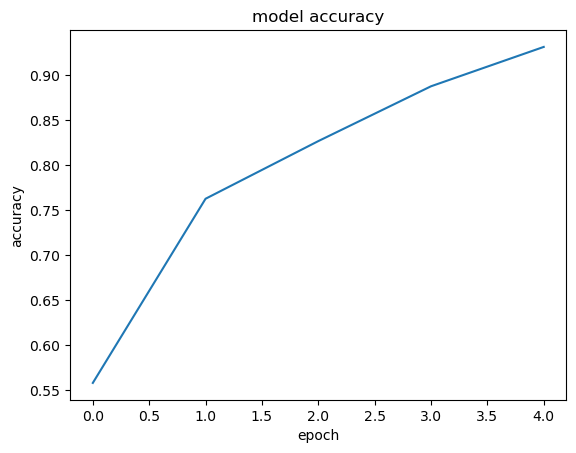

In [33]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

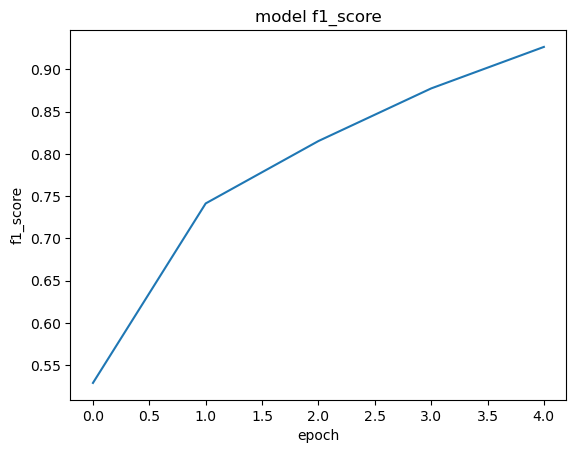

In [34]:
plt.plot(history.history['f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

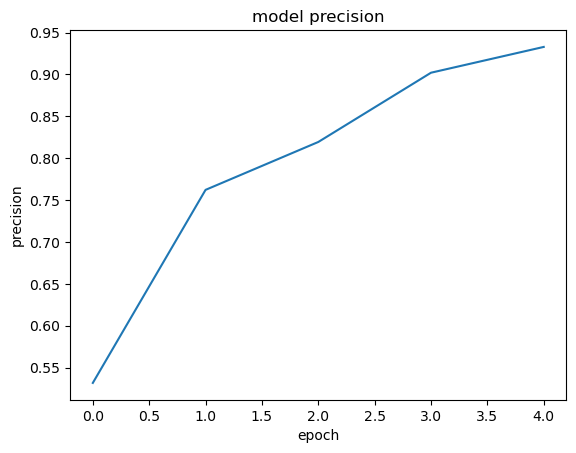

In [35]:
plt.plot(history.history['precision_1'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

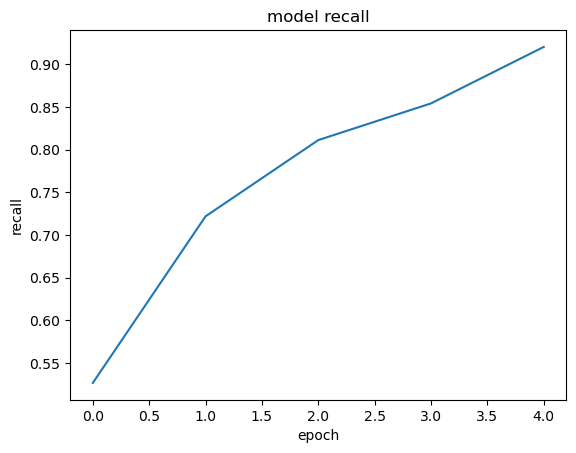

In [36]:
plt.plot(history.history['recall_1'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

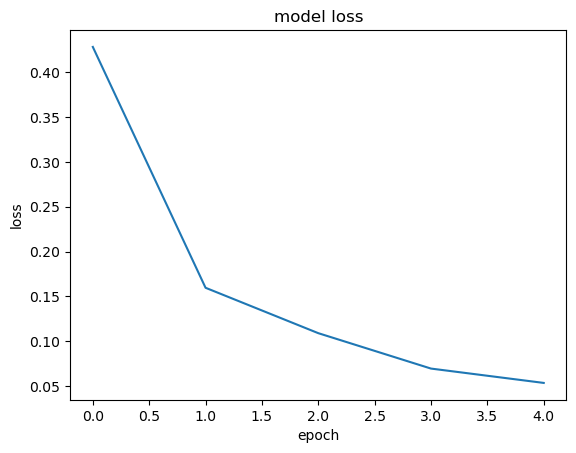

In [37]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [38]:
evaluation = model.evaluate(X_test, y_test)
print(f'Loss: {evaluation[0]}, accuracy: {evaluation[1]}, Recall: {evaluation[2]}, Precision: {evaluation[3]}, AUC: {evaluation[4]}, F1_score: {evaluation[5]}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5726 - auc_1: 0.6505 - f1_score: 0.6205 - loss: 0.2298 - precision_1: 0.5658 - recall_1: 0.6876 
Loss: 0.22520390152931213, accuracy: 0.5874999761581421, Recall: 0.6987951993942261, Precision: 0.5858585834503174, AUC: 0.6657800078392029, F1_score: 0.6373625993728638


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


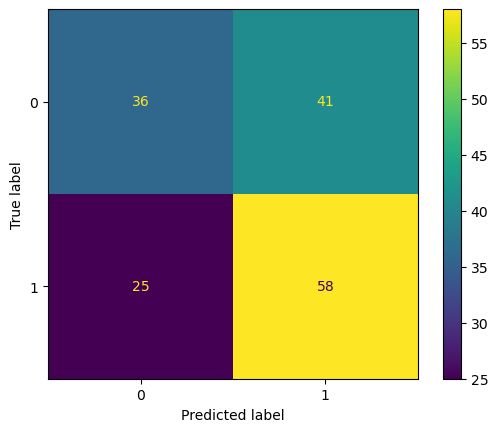

In [39]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
matrix = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(matrix)
display.plot()